# Attention Architecture

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import music21

In [3]:
# from fastai.text import *
from enum import Enum
import torch

In [4]:
import numpy as np
import torch.nn as nn

In [5]:
np.set_printoptions(edgeitems=10, threshold=40, linewidth=200)

In [6]:
import sys
sys.path.insert(0, '../../')
from src.fastai_data import *
from src.encode_data import *
from src.serve import *

In [7]:
from src.music_transformer import *

In [8]:
from src.msklm import *

In [9]:
config = mlm_config(vocab)

In [10]:
# config['n_layers'] = 2
# # config['bptt'] = 512
# config['bs'] = 8
# config['mem_len'] = 32

In [11]:
config

{'ctx_len': 150,
 'n_layers': 8,
 'n_heads': 8,
 'd_model': 512,
 'd_head': 64,
 'd_inner': 2048,
 'resid_p': 0.1,
 'attn_p': 0.1,
 'ff_p': 0.1,
 'embed_p': 0.1,
 'output_p': 0.1,
 'bias': True,
 'scale': True,
 'act': <Activation.GeLU: 3>,
 'double_drop': True,
 'tie_weights': True,
 'out_bias': True,
 'init': <function fastai.text.models.transformer.init_transformer(m)>,
 'mem_len': 512,
 'mask': True,
 'pad_idx': 1,
 'bos_idx': 0,
 'sep_idx': 8,
 'transpose_range': (0, 12),
 'rand_transpose': True,
 'rand_bptt': False,
 'note_range': (9, 137),
 'bs': 16,
 'bptt': 256,
 'vocab_size': 312}

In [12]:
base_path = Path('../../data/midi/v18/sf4/')

In [13]:
cache_name = 'tmp/hook_c'
# cache_name = 'tmp/sample'

## Either or Data

In [14]:
# dl_tfms = [partial(mask_or_lm_tfm, p_lm=0.5)]
dl_tfms = [mask_note_or_dur]
# dl_tfms = [random_msklm_tfm]
msklm_data = MusicDataBunch.load(base_path/'piano_duet', cache_name=cache_name, vocab=vocab, 
                              y_offset=1, dl_tfms=dl_tfms, **config)


In [15]:
xb,yb = msklm_data.one_batch();

## S2S Dataloading

In [16]:
np.pad(np.ones((4,1)), [(1,0),(0,0)], 'constant')

array([[0.],
       [1.],
       [1.],
       [1.],
       [1.]])

In [17]:
m2c_dl_tfms = [s2s_tfm]
m2c_data = MusicDataBunch.load(base_path/'s2s_encode', cache_name=cache_name, 
                               preloader_cls=S2SPreloader, dl_tfms=m2c_dl_tfms,
                               shuffle_dl=True, **config)

c2m_dl_tfms = [partial(s2s_tfm, mlm_type=MLMType.C2M)]
c2m_data = MusicDataBunch.load(base_path/'s2s_encode', cache_name=cache_name, 
                               preloader_cls=S2SPreloader, dl_tfms=c2m_dl_tfms,
                               shuffle_dl=True, **config)

In [18]:
m2c_data.train_dl.dl.dataset.on_epoch_begin()
m2c_data.train_dl.dl.dataset.on_epoch_end()
xb,yb = m2c_data.one_batch(); [x.shape for x in xb], yb[0].shape

([torch.Size([16, 256]),
  torch.Size([16, 256]),
  torch.Size([16, 256]),
  torch.Size([16, 256])],
 torch.Size([16, 256]))

## Datasets

In [19]:
datasets = [msklm_data, m2c_data, c2m_data]
combined_data = CombinedData(datasets)

# datasets = [nw_data]

## MSKLM

## Load

In [20]:
loss_func = MLMLoss()
learn = mlm_model_learner(combined_data, config.copy(), 
# learn = mlm_model_learner(datasets[0], config.copy(), 
                           loss_func=loss_func)

In [21]:
learn.metrics = [acc_ignore_pad, mask_acc, lm_acc, c2m_acc, m2c_acc]

In [22]:
from fastai.callbacks.rnn import RNNTrainer
learn.callbacks = [c for c in learn.callbacks if not isinstance(c, RNNTrainer)]
learn.callbacks.append(MLMTrainer(learn))

In [23]:
[type(c) for c in learn.callbacks]

[src.msklm.MLMTrainer]

In [24]:
learn = learn.to_fp16()

### Training

In [25]:
learn.validate()

[5.96676, tensor(0.0004), tensor(0.), 0, tensor(3.4228e-05), tensor(0.0012)]

In [26]:
# try_pos again - max_norm 0.5
# learn.fit_one_cycle(2, 1e-3)

In [27]:
# learn.save('save_s2s_1')

## Load existing

In [28]:
saved_models = get_files(base_path/'piano_duet/models/mlm/hook_c', recurse=True, extensions=['.pth']); saved_models

[PosixPath('../../data/midi/v18/sf4/piano_duet/models/mlm/hook_c/5_30_reenc_lmonly_best.pth'),
 PosixPath('../../data/midi/v18/sf4/piano_duet/models/mlm/hook_c/8_30_reenc_all_best.pth'),
 PosixPath('../../data/midi/v18/sf4/piano_duet/models/mlm/hook_c/3_ep60.pth'),
 PosixPath('../../data/midi/v18/sf4/piano_duet/models/mlm/hook_c/6_30_reenc_lmonly_best.pth'),
 PosixPath('../../data/midi/v18/sf4/piano_duet/models/mlm/hook_c/6_30_reenc_lmonly.pth'),
 PosixPath('../../data/midi/v18/sf4/piano_duet/models/mlm/hook_c/5_90_reenc_best.pth'),
 PosixPath('../../data/midi/v18/sf4/piano_duet/models/mlm/hook_c/5_30_reenc_lmonly.pth'),
 PosixPath('../../data/midi/v18/sf4/piano_duet/models/mlm/hook_c/4_90_reenc.pth'),
 PosixPath('../../data/midi/v18/sf4/piano_duet/models/mlm/hook_c/8_30_reenc_all.pth'),
 PosixPath('../../data/midi/v18/sf4/piano_duet/models/mlm/hook_c/8_10_reenc_lm.pth'),
 PosixPath('../../data/midi/v18/sf4/piano_duet/models/mlm/hook_c/3_ep60_best.pth'),
 PosixPath('../../data/midi/v18

In [29]:
load_path = saved_models[-5]
state = torch.load(load_path, map_location='cpu')
m = get_model(learn.model)
load_path

PosixPath('../../data/midi/v18/sf4/piano_duet/models/mlm/hook_c/8_30_reenc_all.pth')

In [30]:
m.load_state_dict(state['model'])
load_path

PosixPath('../../data/midi/v18/sf4/piano_duet/models/mlm/hook_c/8_30_reenc_all.pth')

### Set Loss

In [31]:
# def predict_func(parts): return [p if idx == 1 else F.softmax(p, dim=-1) for idx,p in enumerate(parts)]
# loss_func_name = camel2snake(MLMLoss.__name__)
# basic_train.loss_func_name2activ[loss_func_name] = predict_func

## Predict Mask

In [44]:
csv_path = base_path/f'piano_duet/piano_duet.csv'
csv = pd.read_csv(csv_path)
df = csv.loc[csv['numpy'].notna()];

title_filter = df['title'].str.contains('la-bamba')==True
artist_filter = df['artist'].str.contains('valen')==True
results = df[title_filter & artist_filter]; results.head()
results = results[results.source == 'hooktheory_c']; results

,section,ht_key,song_url,midi,artist,md5,numpy,ht_offset,title,midi_title,parts,genres,mxl,source,ht_mode,ht_time_signature,ht_bpm
193208,chorus,C,https://www.hooktheory.com/theorytab/view/ritc...,midi_sources/hooktheory/pianoroll/r/ritchie-va...,ritchie-valen,aeee134e4034e5f98bb630c56d2f7f8c,sf4/piano_duet/hooktheory/pianoroll/r/ritchie-...,0.0,la-bamba,La Bamba,chorus,"Pop,Rock",NaN,hooktheory_c,1.0,4.0,144.0


In [45]:
idx = 0
file = base_path.parent/results.numpy.values[idx];
orig = base_path.parent/results.midi.values[idx];
file, orig

(PosixPath('../../data/midi/v18/sf4/piano_duet/hooktheory/pianoroll/r/ritchie-valen/la-bamba/chorus_key_cmajor.npy'),
 PosixPath('../../data/midi/v18/midi_sources/hooktheory/pianoroll/r/ritchie-valen/la-bamba/chorus_key_cmajor.mid'))

In [46]:
file2stream(orig).show('midi')

In [47]:
song_np = np.load(file)
xb = torch.tensor(song_np)[...,0]
pos = torch.tensor(song_np)[...,1]
if torch.cuda.is_available(): 
    xb = xb.cuda()
    pos = pos.cuda()

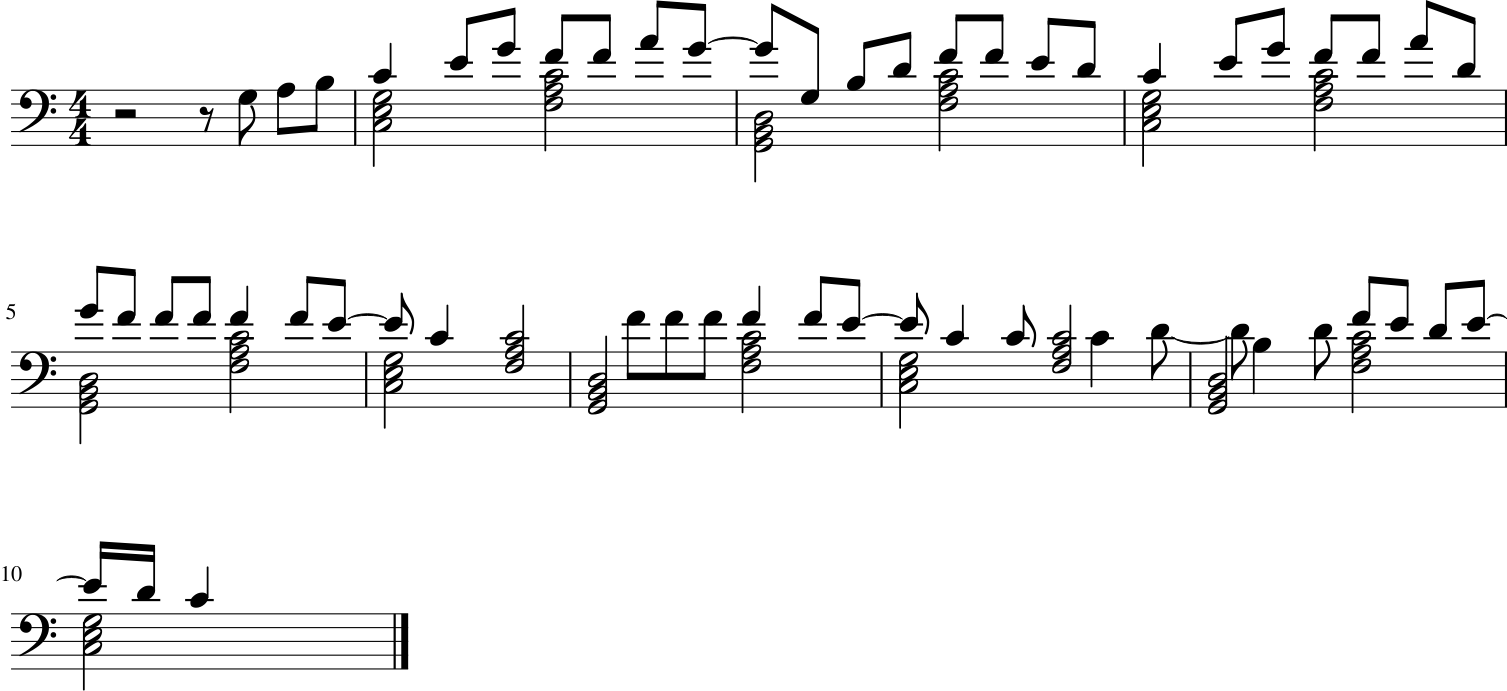

In [48]:
npenc2stream(to_double_stream(xb.cpu().numpy())).show()

#### Regenerate durations

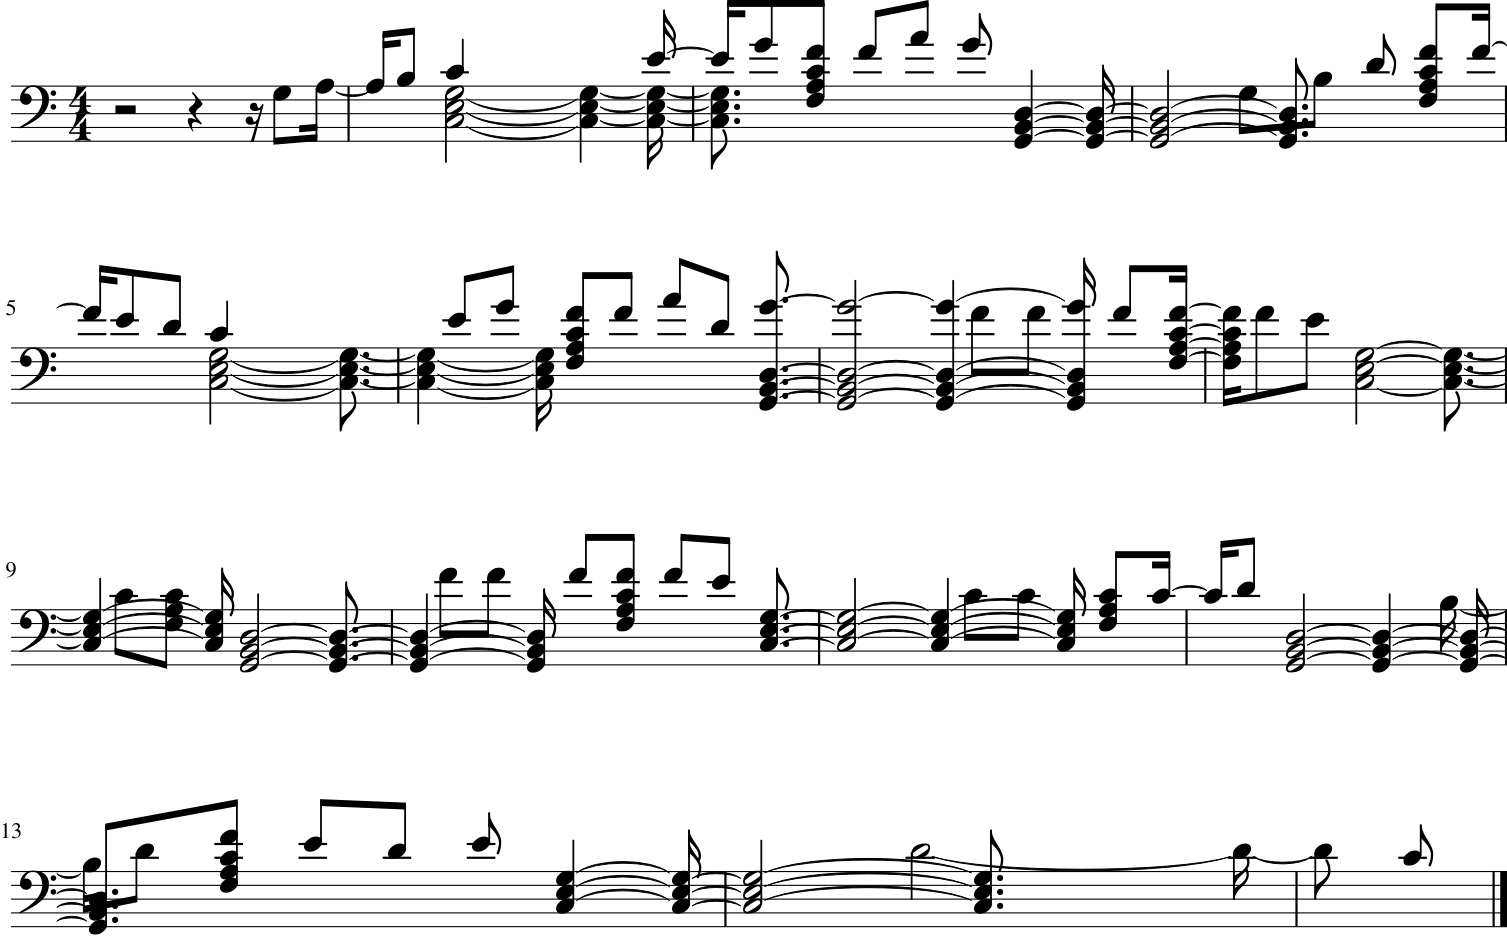

In [62]:
# duration mask
xb_dur = mask_input(xb, mask_range=vocab.dur_range)

pred = learn.predict_mask(xb_dur, pos, temperatures=(0.6,0.6))
pred = to_double_stream(pred)

stream_dur = npenc2stream(pred)
stream_dur.show()

In [63]:
stream_dur.show('midi')

In [59]:

def predict_mask(self, xb:Tensor, pos=None,
                temperatures:float=(1.0,1.0),
                top_k=20, top_p=0.8):
    xb = xb.clone().squeeze()[None]
    if pos is None:
        pos = torch.tensor(-position_enc(xb[0].cpu().numpy()), device=xb.device)[None]
    self.model.reset()
    mask_idxs = (xb == vocab.mask_idx).nonzero()
    for midx in progress_bar(mask_idxs, leave=True):

        # Using original positions, otherwise model gets too off track
#         pos = torch.tensor(-position_enc(xb[0].cpu().numpy()), device=xb.device)[None]

        # Next Word
        res = self.pred_batch(batch=((xb, None, pos, None),xb))
        res = F.softmax(res[tuple(midx)], dim=-1) # task1, task2 - (bs x ts x vocab)

        # Don't allow any special tokens (as we are only removing notes and durations)
        res[vocab.bos_idx] = 0.
        res[vocab.sep_idx] = 0.
        res[vocab.stoi[EOS]] = 0

        # Use first temperatures value if last prediction was duration
        temperature = temperatures[0]
        if temperature != 1.: res.pow_(1 / temperature)

        res = top_k_top_p_filtering(res, top_k=top_k, top_p=top_p, filter_value=0)
        idx = torch.multinomial(res, 1).item()
        #         idx = res.argmax()

        xb[tuple(midx)] = idx

    return xb.cpu().numpy()


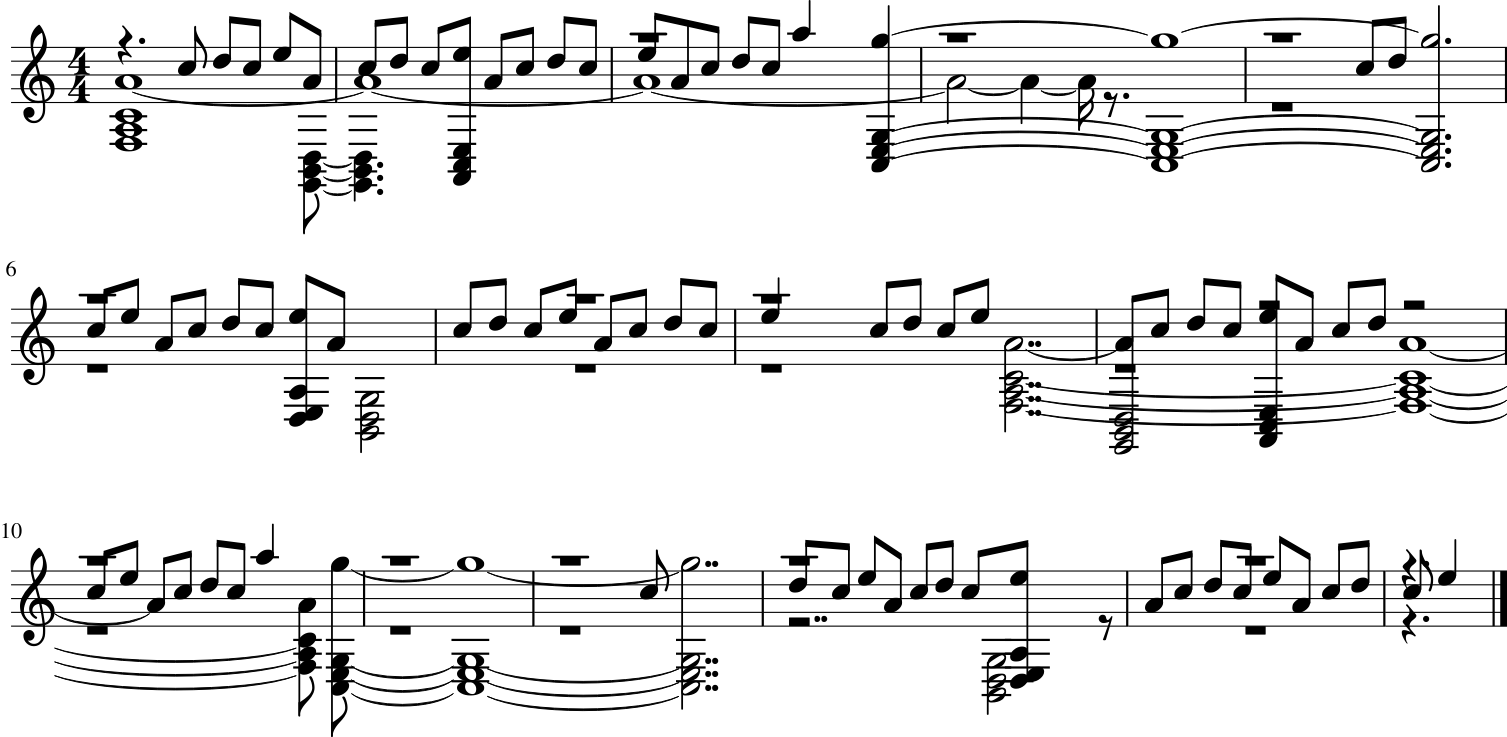

In [62]:
# duration mask

pos = torch.tensor(song_np)[...,1][None]
if torch.cuda.is_available(): pos = pos.cuda()
    
xb_dur = mask_input(xb, mask_range=vocab.dur_range)

pred = predict_mask(learn, xb_dur, pos, temperatures=(0.8,0.8))
pred = to_double_stream(pred)

stream_dur = npenc2stream(pred)
stream_dur.show()

In [63]:
stream_dur.show('midi')

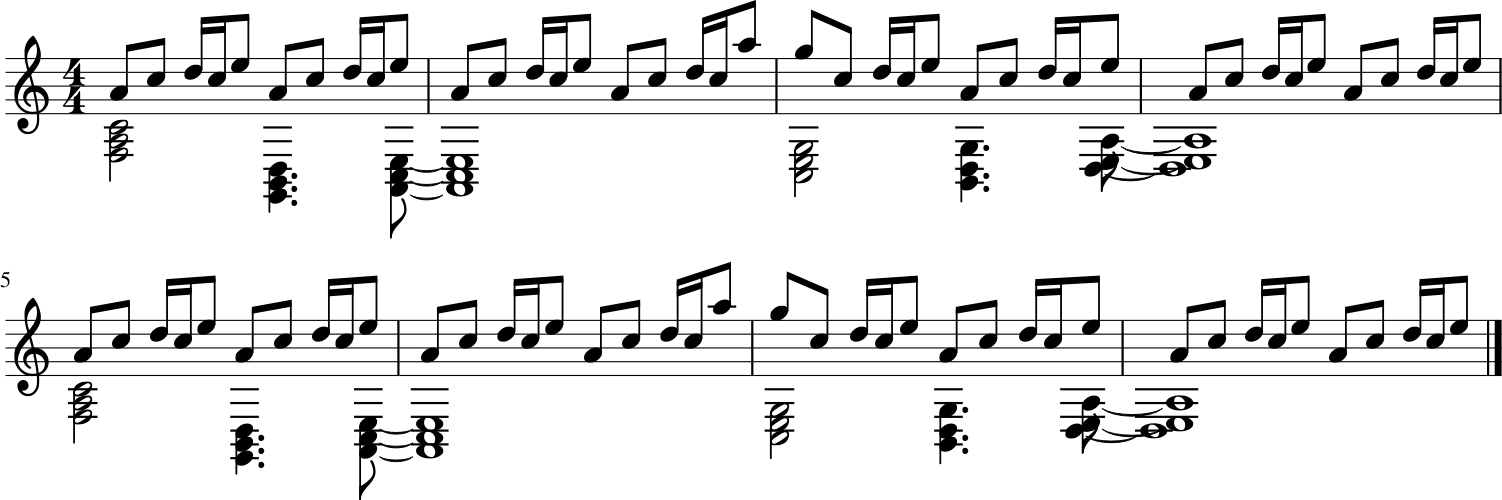

In [36]:
npenc2stream(to_double_stream(xb.cpu().numpy())).show()

#### Regenerate Notes

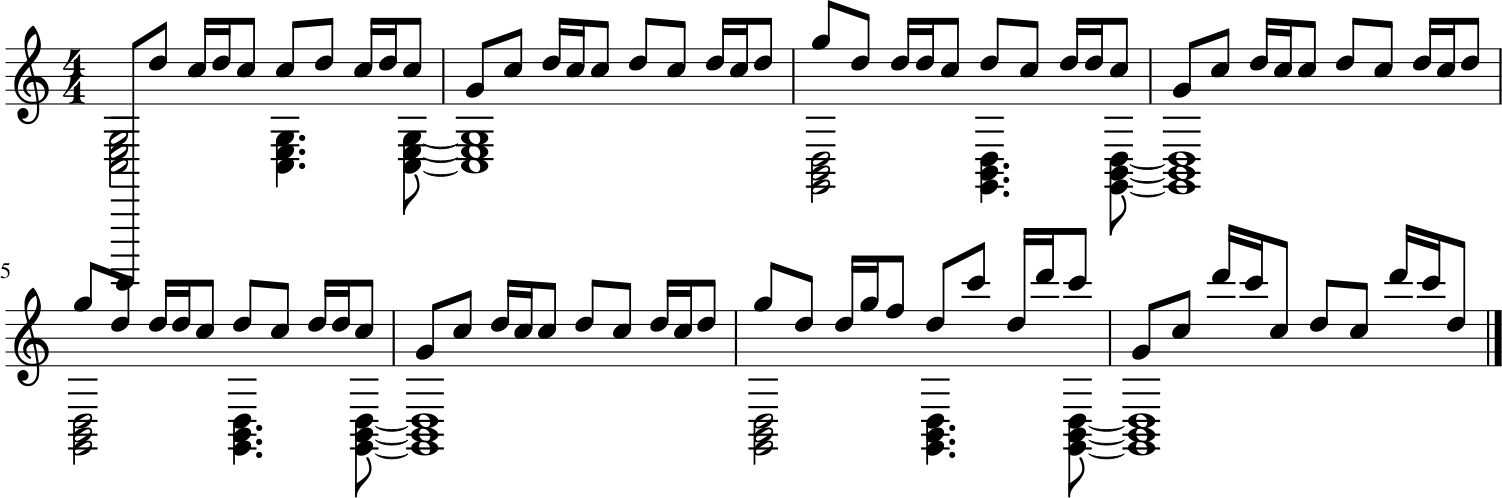

In [40]:
# Mask notes
# nr = vocab.stoi[SEP], vocab.stoi[NOTE_END]+1
xb_note = mask_input(xb, mask_range=vocab.note_range)
pred_note = learn.predict_mask(xb_note)
pred_note = to_double_stream(pred_note)

stream_note = npenc2stream(pred_note)
stream_note.show()

In [41]:
out = mask_predict_from_midi(learn, orig, predict_notes=False)

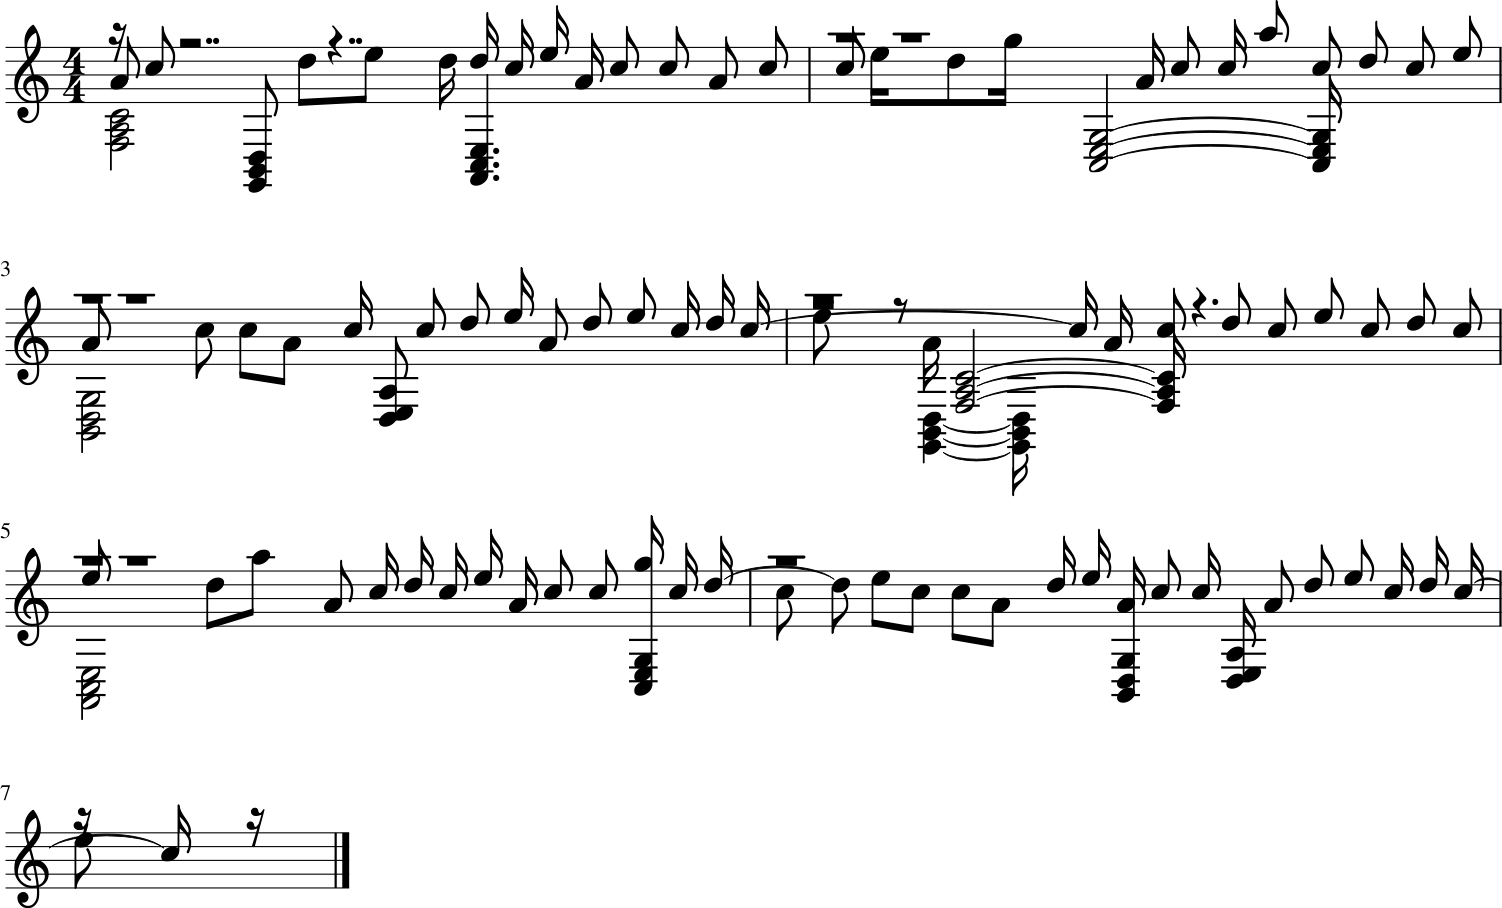

In [42]:
npenc2stream(out).show()

## Prediction next word

In [43]:
csv_path = base_path/f'piano_duet/piano_duet.csv'
csv = pd.read_csv(csv_path)
df = csv.loc[csv['numpy'].notna()];

# keywords = 'la bamba'.replace(' ', '|')
title_filter = df['title'].str.contains('la-bamba')==True
artist_filter = df['artist'].str.contains('')==True
results = df[title_filter & artist_filter]; results.head()
results = results[results.source == 'hooktheory_c']; results.head()

/home/ubuntu/anaconda3/envs/midi/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (0,1,2,9,10,12) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,section,ht_key,song_url,midi,artist,md5,numpy,ht_offset,title,midi_title,parts,genres,mxl,source,ht_mode,ht_time_signature,ht_bpm
193208,chorus,C,https://www.hooktheory.com/theorytab/view/ritc...,midi_sources/hooktheory/pianoroll/r/ritchie-va...,ritchie-valen,aeee134e4034e5f98bb630c56d2f7f8c,sf4/piano_duet/hooktheory/pianoroll/r/ritchie-...,0.0,la-bamba,La Bamba,chorus,"Pop,Rock",NaN,hooktheory_c,1.0,4.0,144.0


In [44]:
idx = 0
file = base_path.parent/results.numpy.values[idx];
orig = base_path.parent/results.midi.values[idx];
file, orig

(PosixPath('../../data/midi/v18/sf4/piano_duet/hooktheory/pianoroll/r/ritchie-valen/la-bamba/chorus_key_cmajor.npy'),
 PosixPath('../../data/midi/v18/midi_sources/hooktheory/pianoroll/r/ritchie-valen/la-bamba/chorus_key_cmajor.mid'))

In [45]:
seed_len = 40
song_np = np.load(file)[:seed_len]
xb = torch.tensor(song_np)
if torch.cuda.is_available(): xb = xb.cuda()

In [46]:
song_np.shape

(40, 2)

In [47]:
# seed_stream = npenc2stream(seed_np)
# seed_stream.show()

In [50]:
out_s, seed_s = learn.predict_nw(x, n_words=200)

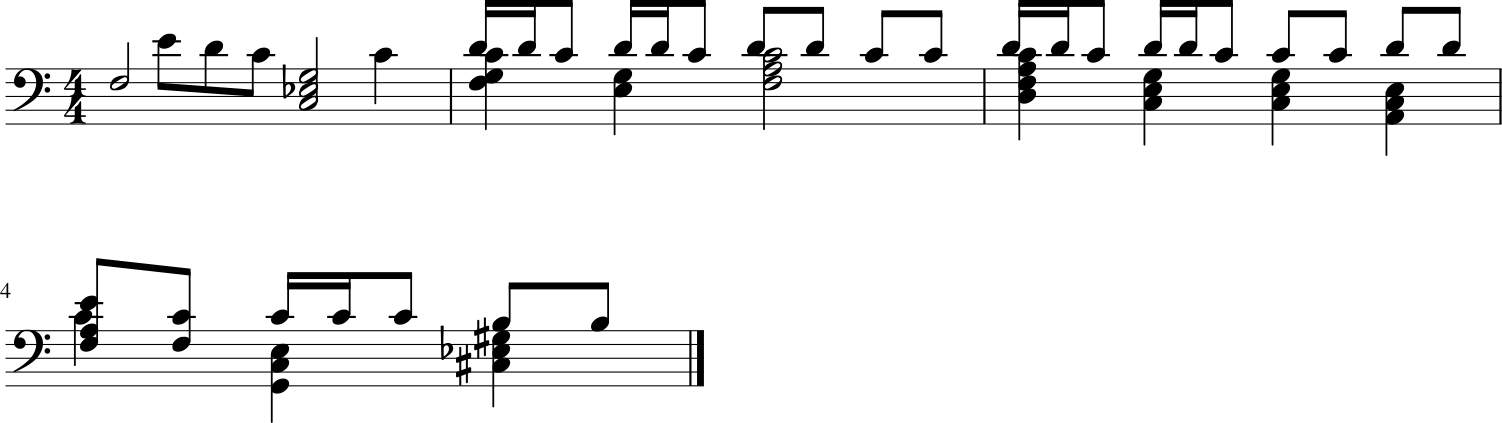

In [51]:
stream = npenc2stream(to_double_stream(out_s))
stream.show()

In [52]:
stream.show('midi')

In [53]:
out = nw_predict_from_midi(learn, orig)

Predicted BOS token. Returning prediction...


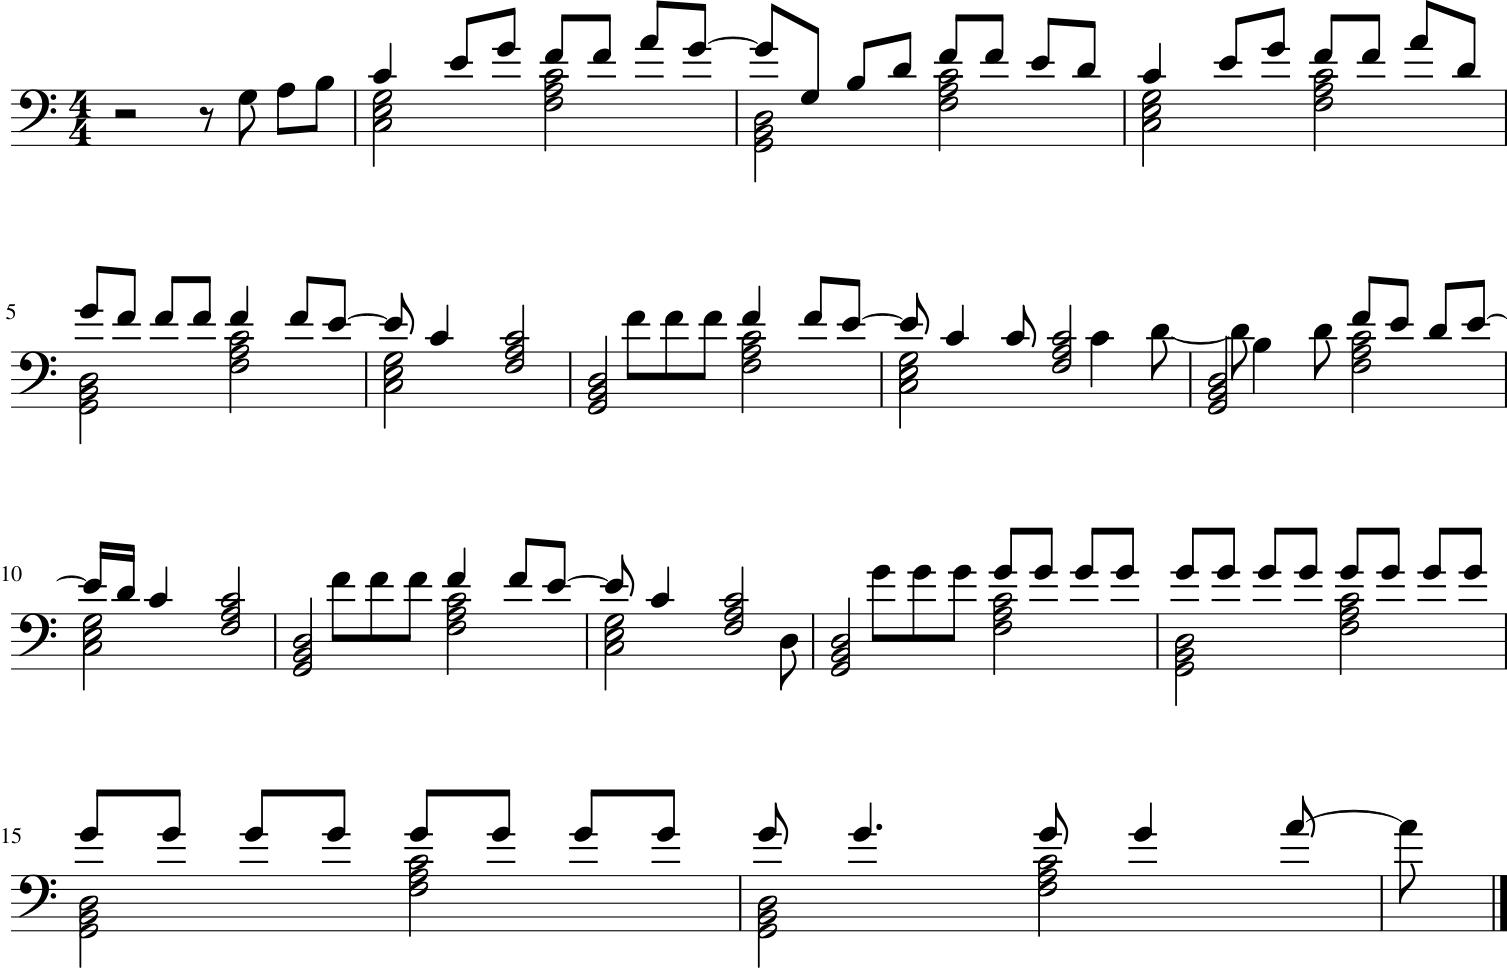

In [54]:
stream = npenc2stream(out)
stream.show()

In [55]:
stream.show('midi')

## Predict Seq2Seq

In [56]:
csv_path = base_path/f's2s_encode/s2s_encode.csv'
csv = pd.read_csv(csv_path)
df = csv.loc[csv['numpy'].notna()];

# keywords = 'la bamba'.replace(' ', '|')
title_filter = df['title'].str.contains('the-nights')==True
artist_filter = df['artist'].str.contains('avicii')==True
results = df[title_filter & artist_filter]; results.head()
results = results[results.source == 'hooktheory_c']; results.head()

/home/ubuntu/anaconda3/envs/midi/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (4,7,9,11,14,16) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,ht_mode,title,genres,source,section,midi,artist,parts,ht_bpm,midi_title,ht_time_signature,ht_key,ht_offset,md5,song_url,numpy,mxl
195795,1.0,the-nights-fifa-15-soundtrack,Pop,hooktheory_c,chorus,midi_sources/hooktheory/pianoroll/a/avicii/the...,avicii,"chorus,instrumental",128.0,The Nights 1,4.0,C,0.0,fa205720e439c7d89e454d595fbffe53,https://www.hooktheory.com/theorytab/view/avic...,sf4/s2s_encode/hooktheory/pianoroll/a/avicii/t...,NaN
195796,1.0,the-nights-fifa-15-soundtrack,Pop,hooktheory_c,instrumental,midi_sources/hooktheory/pianoroll/a/avicii/the...,avicii,"chorus,instrumental",125.0,New Project,4.0,C,0.0,0ec5cd00401250f034aa6e70095b924e,https://www.hooktheory.com/theorytab/view/avic...,sf4/s2s_encode/hooktheory/pianoroll/a/avicii/t...,NaN
195814,1.0,the-nights,"Alt-Country,Children's,Country,Dance,Electroni...",hooktheory_c,chorus,midi_sources/hooktheory/pianoroll/a/avicii/the...,avicii,"verse,verse-and-pre-chorus,pre-chorus,pre-chor...",126.0,The Nights,4.0,C,0.0,38944ab41d16031f9802ed7a0390b332,https://www.hooktheory.com/theorytab/view/avic...,sf4/s2s_encode/hooktheory/pianoroll/a/avicii/t...,NaN
195815,1.0,the-nights,"Alt-Country,Children's,Country,Dance,Electroni...",hooktheory_c,pre-chorus-and-chorus,midi_sources/hooktheory/pianoroll/a/avicii/the...,avicii,"verse,verse-and-pre-chorus,pre-chorus,pre-chor...",128.0,The Nights Pre chorus and chorus,4.0,C,0.0,6ad9f4282c05cb37d6836f8eae74a7a4,https://www.hooktheory.com/theorytab/view/avic...,sf4/s2s_encode/hooktheory/pianoroll/a/avicii/t...,NaN
195816,1.0,the-nights,"Alt-Country,Children's,Country,Dance,Electroni...",hooktheory_c,verse,midi_sources/hooktheory/pianoroll/a/avicii/the...,avicii,"verse,verse-and-pre-chorus,pre-chorus,pre-chor...",126.0,The Nights Verse,4.0,C,0.0,3ce63c4d7c4aea2940daaf9277c0799a,https://www.hooktheory.com/theorytab/view/avic...,sf4/s2s_encode/hooktheory/pianoroll/a/avicii/t...,NaN


In [57]:
idx = 0
file = base_path.parent/results.numpy.values[idx];
orig = base_path.parent/results.midi.values[idx];
file, orig

(PosixPath('../../data/midi/v18/sf4/s2s_encode/hooktheory/pianoroll/a/avicii/the-nights-fifa-15-soundtrack/chorus_key_cmajor.npy'),
 PosixPath('../../data/midi/v18/midi_sources/hooktheory/pianoroll/a/avicii/the-nights-fifa-15-soundtrack/chorus_key_cmajor.mid'))

In [58]:
melody_np, chord_np = np.load(file, allow_pickle=True)

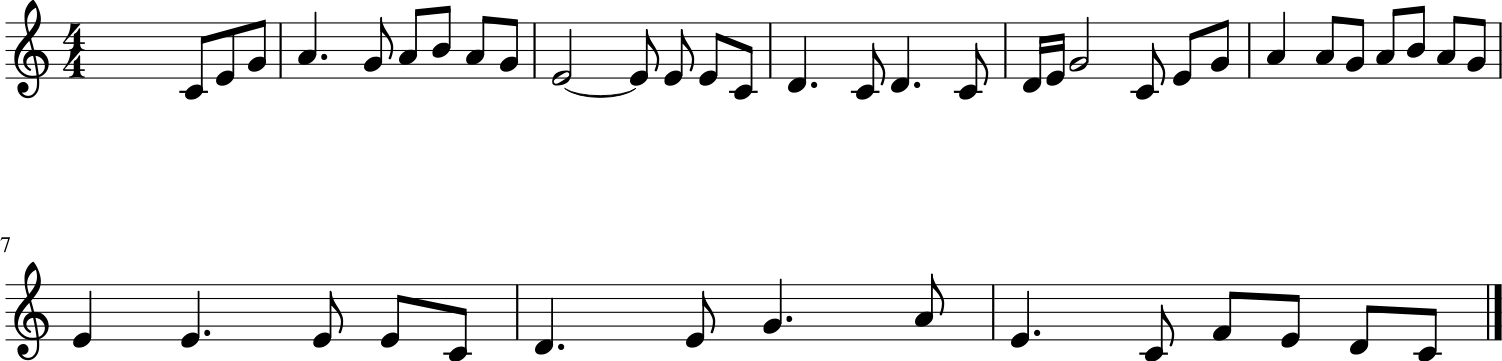

In [59]:
npenc2stream(to_double_stream(melody_np[...,0])).show()

In [60]:
seed_len = 30
xb_msk = torch.tensor(chord_np)[:, 0].cuda()
xb_lm = torch.tensor(melody_np[:50, 0]).cuda()

In [61]:
xb_msk.shape, xb_lm.shape

(torch.Size([75]), torch.Size([50]))

In [64]:
out = learn.predict_s2s(xb_msk, xb_lm)

Predicted past counter-part length. Returning early


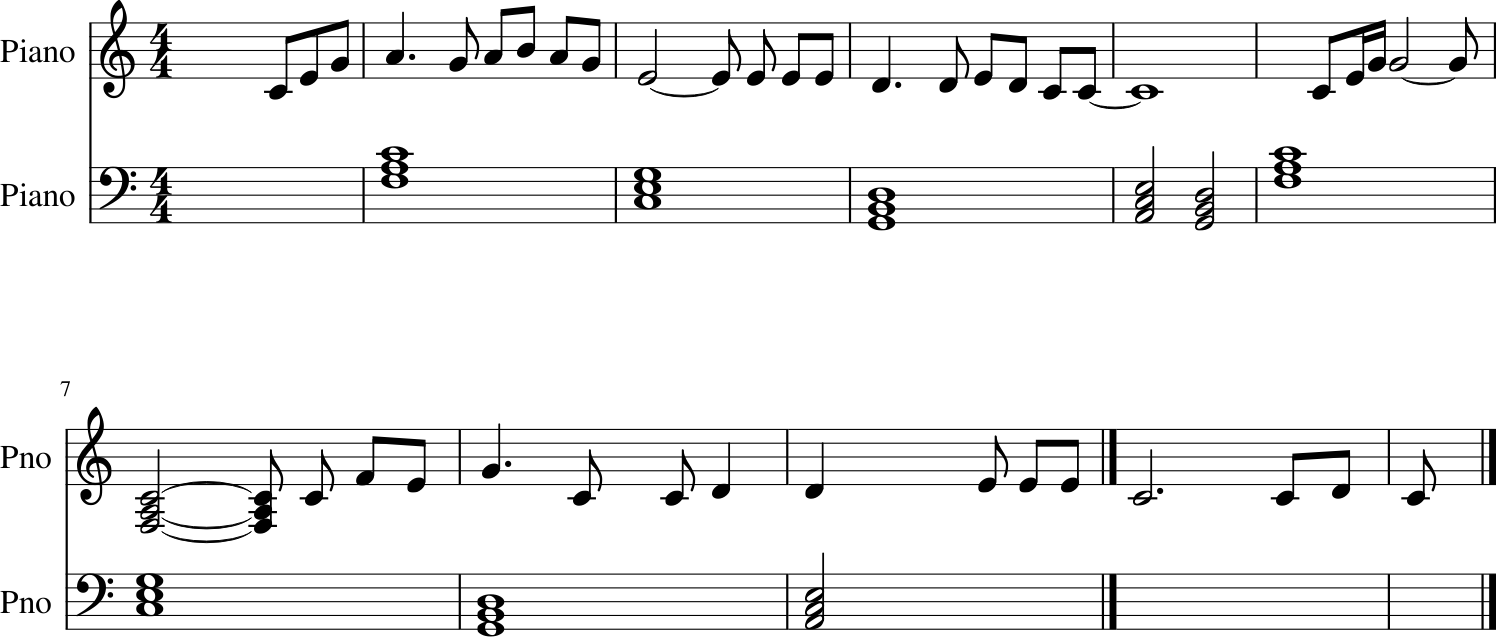

In [65]:
seed_npenc = to_double_stream(xb_msk.cpu().numpy())
yb_npenc = to_double_stream(out)
chordarr_comb = combined_npenc2chordarr(yb_npenc, seed_npenc)
comb_stream = chordarr2stream(chordarr_comb, bpm=108)
comb_stream.show()

In [66]:
comb_stream.show('midi')

In [67]:
out = s2s_predict_from_midi(learn, orig)

Predicted past counter-part length. Returning early


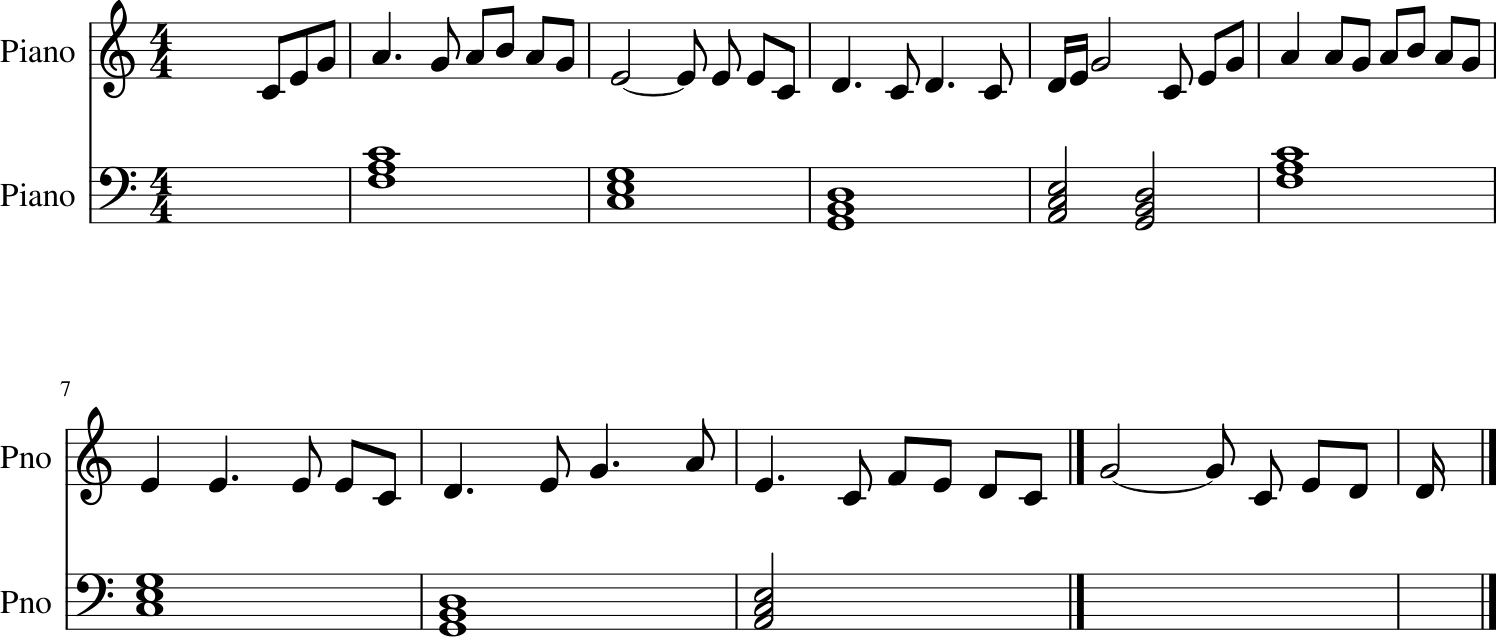

In [68]:
comb_stream = chordarr2stream(out, bpm=108)
comb_stream.show()